## **Classification of Protein Sequences via LSTMs and TCNs with Skip Connections**

Proteins are large, complex bio-molecules responsible for carrying out multiple critical bodily functions.  They are composed of chains (long variable-order sequences with repeats) of 20 possible amino acids.  The constituent amino acids that make up a protein determine its unique structure as well as function.  In this assignment, we will use deep learning and a protein database called 'Pfam' to classify amino acid sequences into their protein families. 

In [ ]:
#1. First download the dataset from here: https://www.kaggle.com/googleai/pfam-seed-random-split
#2. Upload the data folder from #1 to your Google Drive
#MOUNTING GOOGLE DRIVE WHERE DATA IS STORED
from google.colab import drive
drive.mount('/gdrive/', force_remount=True)

In [ ]:
#Required Imports
%matplotlib inline
!pip install einops
!pip install python-Levenshtein

import gc
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
import itertools
import random
from prettytable import PrettyTable
from IPython.display import Image

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import euclidean_distances
from Levenshtein import distance as levenshtein_distance

from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import Conv1D, Add, MaxPooling1D, BatchNormalization
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, GlobalMaxPooling1D


     |████████████████████████████████| 50 kB 2.6 MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=149865 sha256=a8dd9bf1819e32b3553d59bb76b9e9c9ea22aff859b4d599659a3546f35c0382
  Stored in directory: /root/.cache/pip/wheels/05/5f/ca/7c4367734892581bb5ff896f15027a932c551080b2abd3e00d
Successfully built python-Levenshtein


In [ ]:
# Reading in the Pfam dataset
# data is randomly split into three folders [train(80%), test(10%), dev(10%)]
# reading and concatenating data for each folder.

#data_path = '/gdrive/My Drive/Fall 2021/BMEN 4470/random_split/' #Make sure to modify to your location
data_path = '/gdrive/My Drive/random_split/' #Make sure to modify to your location
print('Available data', os.listdir(data_path))

def read_data(partition):
  data = []
  for fn in os.listdir(os.path.join(data_path, partition)):
    with open(os.path.join(data_path, partition, fn)) as f:
      data.append(pd.read_csv(f, index_col=None))
  return pd.concat(data)

# reading all data_partitions and visualizing (head) of the data
df_train = read_data('train')
df_val = read_data('dev')
df_test = read_data('test')
df_train.head()

Available data ['train', 'test', 'dev', 'random_split']


,family_id,sequence_name,family_accession,aligned_sequence,sequence
0,GMC_oxred_C,A4WZS5_RHOS5/416-539,PF05199.13,PHPE.SRIRLST.RRDAHGMP.....IP.RIESRLGP............,PHPESRIRLSTRRDAHGMPIPRIESRLGPDAFARLRFMARTCRAIL...
1,DUF2887,K9QI92_9NOSO/3-203,PF11103.8,RDSIYYQIFKRFPALIFEL..VD.NRPPQAQNYRFESVEVKETAFR...,RDSIYYQIFKRFPALIFELVDNRPPQAQNYRFESVEVKETAFRIDG...
2,zf-IS66,Q92LC9_RHIME/32-75,PF13005.7,.TCCPDCGG.E..LRLVGED.AS....EILDMI.AAQMKVIEVARL...,TCCPDCGGELRLVGEDASEILDMIAAQMKVIEVARLKKSCRCCE
3,Asp_decarbox,X2GQZ4_9BACI/1-115,PF02261.16,MLRMMMNSKIHRATVTEADLNYVGSITIDEDILDAVGMLPNEKVHI...,MLRMMMNSKIHRATVTEADLNYVGSITIDEDILDAVGMLPNEKVHI...
4,Filamin,A7SQM3_NEMVE/342-439,PF00630.19,TACPKQ.CTA....RGLG.............LK.AAPVT.QPT..R...,TACPKQCTARGLGLKAAPVTQPTRFVVILNDCHGQPLGRSEGELEV...


# Overview of Data Components:

*sequence:* This is the input to the model, an amino acid sequence for a protein. There are 20 common amino acids (frequency > 1,000,000), and 4 amino acids that are uncommon: U, B, O, Z, and X stands for an unknown or generic/'wild-card' amino acid.

*family_accession:* These are the labels (outputs) of the model. Accession number is in the form PFxxxxx.y, where xxxxx is the family accession, and y is the version number. Some values of y are greater than ten, and so 'y' has two digits.

*sequence_name:* Sequence name, in the form "uniprot_accession_id/start_index-end_index".

*aligned_sequence:* The aligned version of the *sequence* (above) with gaps retained.

*family_id:* One word name for protein family.


**Getting Familiar with the Data:** the following few cells will help you get familiar with the data, an important step to allow you to build your deep learning sequence model

In [ ]:
# An example unaligned sequence, input to the model
# Each character represents one of the 25 (20 common + 4 uncommon + 1 'wild-card') 
# amino acids in the sequence.

df_train.head(1)['sequence'].values[0]

'PHPESRIRLSTRRDAHGMPIPRIESRLGPDAFARLRFMARTCRAILAAAGCAAPFEEFSSADAFSSTHVFGTCRMGHDPMRNVVDGWGRSHRWPNLFVADASLFPSSGGGESPGLTIQALALRT'

In [ ]:
# Given data size (number of sequences in each set)
print('Train size: ', len(df_train))
print('Val size: ', len(df_val))
print('Test size: ', len(df_test))

Train size:  1086741
Val size:  126171
Test size:  126171


In [ ]:
#Getting a sense of the data: number of families/classes
def calc_unique_cls(train, test, val):
  """
  Prints # unique classes in data sets.
  """
  train_unq = np.unique(train['family_accession'].values)
  val_unq = np.unique(val['family_accession'].values)
  test_unq = np.unique(test['family_accession'].values)

  print('Number of unique classes in Train: ', len(train_unq))
  print('Number of unique classes in Val: ', len(val_unq))
  print('Number of unique classes in Test: ', len(test_unq))

# Unique classes in the given dataset : [df_train, df_val and df_test]
calc_unique_cls(df_train, df_test, df_val)

Number of unique classes in Train:  17929
Number of unique classes in Val:  13071
Number of unique classes in Test:  13071


**Problem 1a:** Use the code in the following cell to plot the typical lengths of sequences in this dataset.  What is the the approximate most prevalent/common sequence length?  You will use this later for pre-processing your sequences.

```The most common sequence length is 69, as determined by the counter.```

---



/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

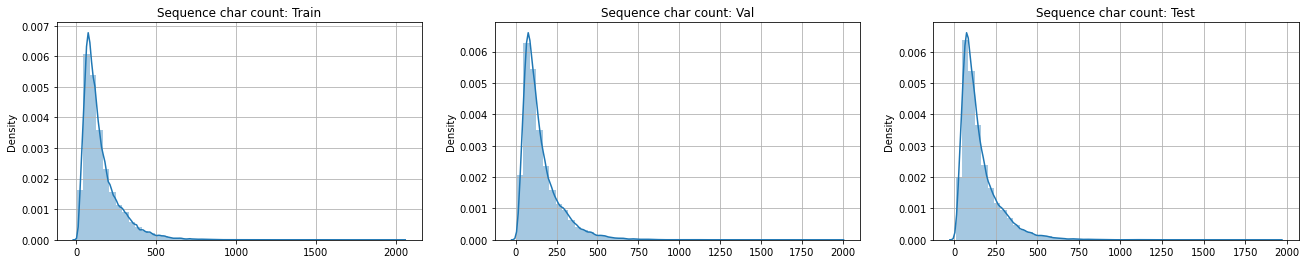

In [ ]:
# The code below will allow you to plot the typical lengths of
# amino acid sequences for train, val, and test datasets.  

df_train['seq_char_count']= df_train['sequence'].apply(lambda x: len(x))
df_val['seq_char_count']= df_val['sequence'].apply(lambda x: len(x))
df_test['seq_char_count']= df_test['sequence'].apply(lambda x: len(x))

def plot_seq_count(df, data_name):
  sns.distplot(df['seq_char_count'].values)
  plt.title(f'Sequence char count: {data_name}')
  plt.grid(True)


plt.subplot(1, 3, 1)
plot_seq_count(df_train, 'Train')

plt.subplot(1, 3, 2)
plot_seq_count(df_val, 'Val')

plt.subplot(1, 3, 3)
plot_seq_count(df_test, 'Test')

plt.subplots_adjust(right=3.0)
plt.show()


In [ ]:
#train
dtrain = df_train['seq_char_count']
c = Counter(dtrain)
print(c.most_common(10)) # 10 most common, [element, count]

[(69, 8860), (68, 8252), (74, 8232), (67, 8004), (85, 7928), (84, 7834), (73, 7772), (75, 7738), (79, 7683), (80, 7662)]


In [ ]:
#val
dval = df_val['seq_char_count']
c = Counter(dval)
print(c.most_common(10)) # 10 most common, [element, count]

[(69, 1074), (68, 973), (67, 961), (75, 928), (74, 926), (73, 918), (84, 907), (63, 900), (65, 891), (72, 889)]


In [ ]:
#test
dtest = df_test['seq_char_count']
c = Counter(dtest)
print(c.most_common(10)) # 10 most common, [element, count]

[(69, 1069), (67, 1019), (85, 949), (68, 944), (80, 935), (75, 923), (84, 920), (74, 916), (73, 894), (81, 886)]


Amino acids are represented in a protein sequence with their corresponding 1 letter code; for example, the code for alanine is (A), arginine is (R), and so on. The complete list of amino acid codes is [here](https://www.ddbj.nig.ac.jp/ddbj/code-e.html) under 'Amino Acid Codes'.

In [ ]:
#Determine the number of instances of each amino acid code across all sequences
#in train, val, and test sets 
def get_code_freq(df, data_name):
  
  df = df.apply(lambda x: " ".join(x))
  
  codes = []
  for i in df: # concatination of all codes
    codes.extend(i)

  codes_dict= Counter(codes)
  codes_dict.pop(' ') # removing white space
  
  print(f'Codes: {data_name}')
  print(f'Total unique codes: {len(codes_dict.keys())}')

  df = pd.DataFrame({'Code': list(codes_dict.keys()), 'Freq': list(codes_dict.values())})
  return df.sort_values('Freq', ascending=False).reset_index()[['Code', 'Freq']]
  
# train code sequence
train_code_freq = get_code_freq(df_train['sequence'], 'Train')

# val code sequence
val_code_freq = get_code_freq(df_val['sequence'], 'Val')

# test code sequence
test_code_freq = get_code_freq(df_test['sequence'], 'Test')

def plot_code_freq(df, data_name):
  
  plt.title(f'Code frequency: {data_name}')
  sns.barplot(x='Code', y='Freq', data=df)

Codes: Train
Total unique codes: 25
Codes: Val
Total unique codes: 22
Codes: Test
Total unique codes: 24


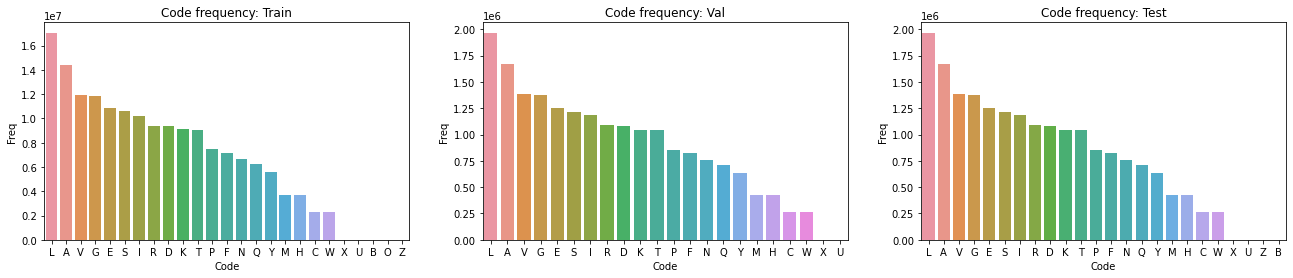

In [ ]:
#Plot the Amino Acid Code frequency for this dataset
plt.subplot(1, 3, 1)
plot_code_freq(train_code_freq, 'Train')

plt.subplot(1, 3, 2)
plot_code_freq(val_code_freq, 'Val')

plt.subplot(1, 3, 3)
plot_code_freq(test_code_freq, 'Test')

plt.subplots_adjust(right=3.0)
plt.show()

In [ ]:
# Since our dataset is large, we will consider only the top 300 most-observed
# protein classes/families due to limited computational power.

classes = df_train['family_accession'].value_counts()[:300].index.tolist()
len(classes)

# Filtering data based on considered 300 classes.
train_sm = df_train.loc[df_train['family_accession'].isin(classes)].reset_index()
val_sm = df_val.loc[df_val['family_accession'].isin(classes)].reset_index()
test_sm = df_test.loc[df_test['family_accession'].isin(classes)].reset_index()

print('Data size after considering 300 classes for each data split:')
print('Train size :', len(train_sm))
print('Val size :', len(val_sm))
print('Test size :', len(test_sm))

# No. of unique classes after reducing the data size.

calc_unique_cls(train_sm, test_sm, val_sm)

Data size after considering 300 classes for each data split:
Train size : 210358
Val size : 26129
Test size : 26129
Number of unique classes in Train:  300
Number of unique classes in Val:  300
Number of unique classes in Test:  300


Here we start developing our **Deep Learning** model.  First task is to preprocess the amino acid sequences in our dataset.

In [ ]:
# The code below creates our amino acid code sequence dictionary
# https://dmnfarrell.github.io/bioinformatics/mhclearning
# 1 letter code for 20 natural amino acids

codes = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
         'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

def create_dict(codes):
  char_dict = {}
  for index, val in enumerate(codes):
    char_dict[val] = index+1

  return char_dict

char_dict = create_dict(codes)

print(char_dict)
print("Dict Length:", len(char_dict))

{'A': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'V': 18, 'W': 19, 'Y': 20}
Dict Length: 20


In [ ]:
#Now we will encode our sequences made of letters into sequences of integers
def integer_encoding(data):
  """
  - Encodes code sequence to integer values.
  - 20 common amino acids (and X 'wild-card') are taken into consideration.
    Remaining 4 uncommon amino acids are categorized as 0 (so not included).
  """
  
  encode_list = []
  for row in data['sequence'].values:
    row_encode = []
    for code in row:
      row_encode.append(char_dict.get(code, 0))
    encode_list.append(np.array(row_encode))
  
  return encode_list
  
train_encode = integer_encoding(train_sm) 
val_encode = integer_encoding(val_sm) 
test_encode = integer_encoding(test_sm) 

#Just to visualize an example of the output
print(train_encode[0])

[16  4  8  9 10 10  7  1 14 18 12 13  7  5 10  5 12  1 10 12 17 10 16  1
 18  8 15 15  3 13  4  9  1  2  7 10 18 10 12 10 16 17  5  5 15  9 12 10
  9 15 13 16  4  4  1  1 10 16  4  4 18  1  7 18  1  1 20 10  4  8  4 14
  1 15  5 10  3  9 10]


In [ ]:
# The code to encode labels/output variable y (amino acid family/class) into integers
le = LabelEncoder()

y_train_le = le.fit_transform(train_sm['family_accession'])
y_val_le = le.transform(val_sm['family_accession'])
y_test_le = le.transform(test_sm['family_accession'])

y_train_le.shape, y_val_le.shape, y_test_le.shape

((210358,), (26129,), (26129,))

**Problem 1b:** Now we must ensure all sequences are the same length since our sequence model can only take in fixed-size inputs.  Pad the sequences using Keras *pad_sequences* [function](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences), using the max_length you determined in part (a).  Use 'post' padding to pad with 0 if the total sequence length is less than max_length or truncate the sequence (if longer) to max_length.

In [ ]:
# Your code below for padding sequences

max_length = 69
train_pad = pad_sequences(train_encode, maxlen=max_length, padding='post', truncating='post')
val_pad = pad_sequences(val_encode, maxlen=max_length, padding='post', truncating='post')
test_pad = pad_sequences(test_encode, maxlen=max_length, padding='post', truncating='post')

# Visualize the padded/truncated version of train_encode
print(train_pad[0])
train_pad.shape, val_pad.shape, test_pad.shape

[16  4  8  9 10 10  7  1 14 18 12 13  7  5 10  5 12  1 10 12 17 10 16  1
 18  8 15 15  3 13  4  9  1  2  7 10 18 10 12 10 16 17  5  5 15  9 12 10
  9 15 13 16  4  4  1  1 10 16  4  4 18  1  7 18  1  1 20 10  4]


((210358, 69), (26129, 69), (26129, 69))

**Problem 1c:** Now encode input sequences and output labels using one-hot encoding (zeros everywhere except for at location of the appropriate amino acid code) using Keras *to_categorical* function.

In [ ]:
# Your code here: One hot encoding of sequences

train_onehot = to_categorical(train_pad)
val_onehot = to_categorical(val_pad)
test_onehot = to_categorical(test_pad)

train_onehot.shape, val_onehot.shape, test_onehot.shape

((210358, 69, 21), (26129, 69, 21), (26129, 69, 21))

In [ ]:
# Your code here: One hot encoding of outputs

y_train = to_categorical(y_train_le)
y_val = to_categorical(y_val_le)
y_test = to_categorical(y_test_le)

y_train.shape, y_val.shape, y_test.shape

((210358, 300), (26129, 300), (26129, 300))

In [ ]:
#Utility functions: plot model's accuracy and loss

# https://realpython.com/python-keras-text-classification/
plt.style.use('ggplot')

def plot_history(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  x = range(1, len(acc) + 1)

  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.plot(x, acc, 'b', label='Training acc')
  plt.plot(x, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(x, loss, 'b', label='Training loss')
  plt.plot(x, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

# Utility function: Display model score(Loss & Accuracy) across all sets.

def display_model_score(model, train, val, test, batch_size):

  train_score = model.evaluate(train[0], train[1], batch_size=batch_size, verbose=1)
  print('Train loss: ', train_score[0])
  print('Train accuracy: ', train_score[1])
  print('-'*70)

  val_score = model.evaluate(val[0], val[1], batch_size=batch_size, verbose=1)
  print('Val loss: ', val_score[0])
  print('Val accuracy: ', val_score[1])
  print('-'*70)
  
  test_score = model.evaluate(test[0], test[1], batch_size=batch_size, verbose=1)
  print('Test loss: ', test_score[0])
  print('Test accuracy: ', test_score[1])

**Problem 1d:** Implement code here for a [bidirectional LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional) using Keras Functional or Sequential API.  Unlike RNNs which only take input from the previous timestep, LSTMs can remember information from the distant past via gating mechanisms.  Bidirectional LSTMs can incorporate contextual information from both past and future, improving their performance even more compared to unidirectional LSTMs on sequential data.

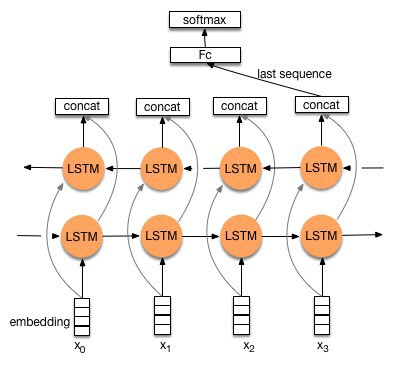

In [ ]:
# Implement your code here:
# Hint: use an embedding layer to project your sequence data to a higher dimension,
# and use the diagram above for some ideas on layers to include in your model.
# Remember to compile your model after designing it.

# define layers
inputs = Input(shape=(max_length,)) # match pad shape
embedding = Embedding(21, 128, input_length=max_length) #switched max_length with 21
x = embedding(inputs)
x = Bidirectional(LSTM(64))(x)
x = Dropout(0.3)(x)
outputs = Dense(300, activation='softmax')(x)

# define model
model1 = Model(inputs=inputs, outputs=outputs, name='Bidirectional_LSTM')

# compile model
model1.compile(optimizer='adam', 
               loss='categorical_crossentropy', 
               metrics=['accuracy'])

# print model summary
model1.summary()

Model: "Bidirectional_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 69)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 69, 128)           8832      
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               98816     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               38700     
Total params: 146,348
Trainable params: 146,348
Non-trainable params: 0
_________________________________________________________________


**Problem 1e:** Now train your model using Keras model.fit function. Add the given early stopping as a parameter to your fit function to prevent overtraining.  Use at least 10 epochs (it will take 15-20min to train with GPU: Remember turn GPU on by going to Runtime --> Change Runtime Type --> GPU) and a batch size of 256.  Validate on your padded validation sequences from above.

In [ ]:
# Train your model using Early Stopping
es = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

history1 = model1.fit(
    train_pad, y_train,
    epochs=10, batch_size=256,
    validation_data=(val_pad, y_val),
    callbacks=[es])

Epoch 1/10
822/822 [==============================] - 38s 36ms/step - loss: 3.3909 - accuracy: 0.3062 - val_loss: 1.5639 - val_accuracy: 0.6886
Epoch 2/10
822/822 [==============================] - 29s 35ms/step - loss: 1.1282 - accuracy: 0.7563 - val_loss: 0.6274 - val_accuracy: 0.8738
Epoch 3/10
822/822 [==============================] - 32s 39ms/step - loss: 0.6095 - accuracy: 0.8650 - val_loss: 0.3734 - val_accuracy: 0.9225
Epoch 4/10
822/822 [==============================] - 31s 38ms/step - loss: 0.4215 - accuracy: 0.9042 - val_loss: 0.2627 - val_accuracy: 0.9447
Epoch 5/10
822/822 [==============================] - 28s 35ms/step - loss: 0.3262 - accuracy: 0.9246 - val_loss: 0.2012 - val_accuracy: 0.9561
Epoch 6/10
822/822 [==============================] - 29s 35ms/step - loss: 0.2639 - accuracy: 0.9375 - val_loss: 0.1631 - val_accuracy: 0.9633
Epoch 7/10
822/822 [==============================] - 30s 36ms/step - loss: 0.2230 - accuracy: 0.9468 - val_loss: 0.1434 - val_accuracy:

822/822 [==============================] - 13s 16ms/step - loss: 0.0656 - accuracy: 0.9863
Train loss:  0.06557691842317581
Train accuracy:  0.9862995743751526
----------------------------------------------------------------------
103/103 [==============================] - 2s 17ms/step - loss: 0.0973 - accuracy: 0.9765
Val loss:  0.09728921949863434
Val accuracy:  0.9764629602432251
----------------------------------------------------------------------
103/103 [==============================] - 2s 15ms/step - loss: 0.0977 - accuracy: 0.9763
Test loss:  0.09767093509435654
Test accuracy:  0.9762715697288513


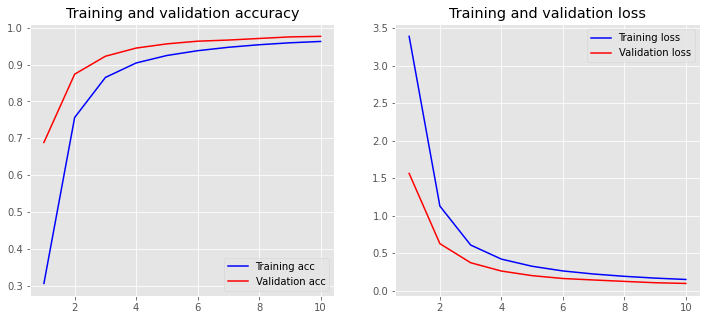

In [ ]:
# Show your model results and plots
display_model_score(model1,
    [train_pad, y_train],
    [val_pad, y_val],
    [test_pad, y_test],
    256)

plot_history(history1)

In [ ]:
#Save your model in case you need to run again to save time with training
#model1.save_weights('/gdrive/My Drive/Fall 2021/BMEN 4470/LSTM_Model1.h5')
model1.save_weights('/gdrive/My Drive/LSTM_Model1.h5')

**Problem #2a**: In this problem, we will assess the interclass variability of embeddings. We will plot t-SNE clusters within and between family_accession samples.  

Extract the weights from the embedding layer of your model1. The shape of your weight matrix should make sense - it should be (sequence_length x embedding_dim)

In [ ]:
embedding_weights = embedding.get_weights()[0]
embedding_weights.shape

(69, 128)

Within 5 classes, compute the embeddings for each sample in your validation set, storing them as you go to a new data matrix (X). 

In [ ]:
from einops import rearrange
num_classes = 5 # number of classes we will store average distances for

X = None
y = None
for class_of_interest in classes[:num_classes]:
  # e.g. class_of_interest == 'PF01967.21'
  class_indices = list(val_sm.loc[val_sm.family_accession==class_of_interest].index)
  
  #val_onehot_flat = val_onehot.flatten()
  #embedding_weights_flat = embedding_weights.flatten()
  
  all_class_samples = np.dot(val_onehot, embedding_weights)
  # Storing the forward pass from the val_ohe samples that match your class_of_interest.

  # this rearranges to samples x features shape by flattening time and embedding shapes
  all_class_samples = rearrange(all_class_samples,'s t e -> s (t e)') 
  if X is None:
    X = all_class_samples
    y = np.array([class_of_interest] * len(class_indices))
  else:
    X = np.concatenate((X, all_class_samples))
    y = np.concatenate((y, np.array([class_of_interest] * len(class_indices)))) 

ValueError: ignored

In [ ]:
embedding_weights

array([[ 0.28826538, -0.32676592, -0.10027502, ..., -0.03203049,
         0.11444444, -0.27612343],
       [ 0.08043172,  0.01673465,  0.08790924, ..., -0.12787178,
         0.13362123, -0.12835526],
       [ 0.25182918, -0.06299692, -0.12540402, ..., -0.06475598,
        -0.23995858,  0.03784046],
       ...,
       [ 0.0412071 , -0.0161279 ,  0.04429877, ..., -0.02809579,
         0.03458084, -0.01155783],
       [ 0.00739034, -0.00531257,  0.03976116, ...,  0.03727578,
        -0.04089776,  0.02267856],
       [ 0.04536966,  0.04727152, -0.03405159, ...,  0.00239642,
         0.01576973, -0.00170218]], dtype=float32)

**Problem #2b**: Use t-SNE to fit and transform your X matrix to 2 components for visualization. 

*Answer the following questions from your plot*:

What do you notice about the clusters? Why does this result occur and how does it help the LSTM model better learn to classify protein function? 

In [ ]:
from sklearn.manifold import TSNE
# Your t-SNE code here
#from tsnecuda import TSNE
X_embedded = TSNE(n_components=2, perplexity=15, learning_rate=10).fit_transform(X)

In [ ]:
import seaborn as sns

# this should plot your lower-dimensional representations of samples, colored by family_accession
tsne_df = pd.DataFrame()
tsne_df['y'] = y
tsne_df['tsne-dim1'] = tsne_results[:,0]
tsne_df['tsne-dim2'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-dim1", y="tsne-dim2",
    hue="y",
    palette=sns.color_palette("hls", num_classes),
    data=tsne_df,
    legend="full",
    alpha=0.6
)

Your answer to the questions here.

Clear variables in case we run into RAM issues with Colab updates

In [ ]:
import gc

try:
  del tsne_results
  del tsne_df
  del embeddings
  del model1
  del df_train
  del df_val
  del df_test
  del train_encode
  del val_encode
  del test_encode
  del y_train_le
  del y_val_le
  del y_test_le
  del train_pad
  del val_pad
  del test_pad
  gc.collect()
except:
  pass

**Problem #3a:** Now we will repeat the protein sequence classification task of Problem #1  using a ResNet based [temporal (1D) convolution network](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D) with dilation.  Use Keras functional API to design two convolutional blocks and then use the Add() [function](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Add) to combine your input (data) with the output of your 2nd convolutional block.

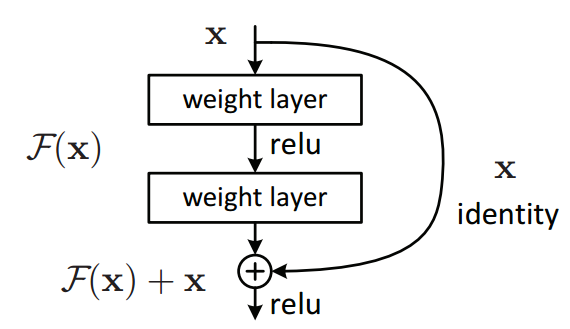

In [ ]:
#Add your code to define a residual block below, as shown in the diagram above
def residual_block(data, filters, d_rate):
  """
  _data: input
  _filters: convolution filters
  _d_rate: dilation rate
  """
  shortcut = data
  
  #dilation
  bn1 = BatchNormalization()(data)
  act1 = Activation('relu')(bn1)
  conv1 = Conv1D(filters, 1, dilation_rate=d_rate, padding='same', kernel_regularizer=l2(0.001))(act1)

  #bottleneck convolution
  bn2 = BatchNormalization()(conv1)
  act2 = Activation('relu')(bn2)
  conv2 = Conv1D(filters, 3, padding='same', kernel_regularizer=l2(0.001))(act2)

  #skip connection
  x = Add()([conv2, shortcut])


  return x

**Problem 3b:** Design a simple 1D temporal convolution network around the residual networks (called below using the definition you implemented in part a) with Keras Functional API.  Include an input layer and convolution layer before the residual networks and max pooling, dropout, flatten, and output dense layers after them.  You can refer to this [paper](https://www.biorxiv.org/content/10.1101/626507v4.full) which describes the final architecture in more detail.

In [ ]:
#Insert your code below

#input
x_input = Input(shape=(69, 21))

#initial conv
conv = Conv1D(128, 1, padding='same')(x_input) 

# per-residue representation
res1 = residual_block(conv, 128, 2)
res2 = residual_block(res1, 128, 3)

#Max Pooling
x = MaxPooling1D(3)(res2)
x = Dropout(0.5)(x)

#softmax classifier
x = Flatten()(x)
x_output = Dense(1000, activation='softmax', kernel_regularizer=l2(0.0001))(x)

#Compile your model
model2 = Model(inputs=x_input, outputs=x_output)
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model2.summary()



**Problem 3c:** Train your model with early stopping using 10 epochs and a batch size of 256.  Validate with your one-hot-encoded validation data from above.

In [ ]:
# Early Stopping
es = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

#your code here
history2 = model2.fit(
    train_pad, y_train,
    epochs=10, batch_size=256,
    validation_data=(val_pad, y_val),
    callbacks=[es]
    )


In [ ]:
#Plot loss and accuracy and evaluate your model.
plot_history(history2)
display_model_score(
    model2,
    [train_ohe, y_train],
    [val_ohe, y_val],
    [test_ohe, y_test],
    256)

**Problem 3d:** Provide a brief comparison of your two models in a markdown cell.  What were their train, val, and test accuracies?  Which one performed better?  Why do you think this is the case?

Write your answer here...

**What to Submit:** Submit this ipynb with your code and short written responses in markdown cells by **November 7th at 11:59pm**.